### Open this notebook in Colab and connect to GPU

In [25]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

# prevent ultralytics from tracking your activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.9.12 torch-2.0.0 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 448.3/460.4 GB disk)


#### 1. Load datasets

In [26]:
# Load field dataset
!curl -L "https://app.roboflow.com/ds/u3XaPUMqaV?key=gYhHkujuQS" > roboflow.zip; mkdir -p field_dataset && unzip roboflow.zip -d field_dataset; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   3469      0 --:--:-- --:--:-- --:--:--  3459:-- --:--:-- --:--:--     0
100 73.6M  100 73.6M    0     0  5897k      0  0:00:12  0:00:12 --:--:-- 9037k 0:00:04  0:00:23 2910k
Archive:  roboflow.zip
  inflating: field_dataset/README.dataset.txt  
  inflating: field_dataset/README.roboflow.txt  
  inflating: field_dataset/data.yaml  
   creating: field_dataset/test/
   creating: field_dataset/test/images/
 extracting: field_dataset/test/images/08fd33_2_9_png.rf.f67c316b2c90614f187415387087c374.jpg  
 extracting: field_dataset/test/images/08fd33_4_11_png.rf.b451e839bdc25b39a1fd967e10631411.jpg  
 extracting: field_dataset/test/images/08fd33_4_3_png.rf.350d911cd01a4cfea62a12e93e046463.jpg  
 extracting: field_dataset/test/images/08fd33_9_2_png.rf.c60ed33c434839548fcbdf985dd78417.jpg  
 extracting: fiel

In [27]:
import pandas as pd
import os
from pathlib import Path

# Function to load dataset split into a dataframe
def load_dataset_split(split_name):
    """
    Load images and labels from a dataset split into a dataframe.
    
    Args:
        split_name: Name of the split ('train', 'valid', or 'test')
    
    Returns:
        DataFrame with columns: image_path, label_path, filename, split
    """
    split_dir = Path(split_name)
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    
    # Get all image files
    image_files = sorted(images_dir.glob('*.jpg'))
    
    data = []
    for img_path in image_files:
        # Get corresponding label file (same name but .txt extension)
        label_filename = img_path.stem + '.txt'
        label_path = labels_dir / label_filename
        
        data.append({
            'image_path': str(img_path),
            'label_path': str(label_path) if label_path.exists() else None,
            'filename': img_path.name,
            'split': split_name
        })
    
    return pd.DataFrame(data)

# Load train, validation, and test sets
train_df = load_dataset_split('field_dataset/train')
valid_df = load_dataset_split('field_dataset/valid')
test_df = load_dataset_split('field_dataset/test')

# Display summary
print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(valid_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nTotal samples: {len(train_df) + len(valid_df) + len(test_df)}")

# Display first few rows of each dataframe
print("\n=== Train DataFrame (first 5 rows) ===")
print(train_df.head())
print("\n=== Validation DataFrame (first 5 rows) ===")
print(valid_df.head())
print("\n=== Test DataFrame (first 5 rows) ===")
print(test_df.head())


Train set: 255 samples
Validation set: 34 samples
Test set: 28 samples

Total samples: 317

=== Train DataFrame (first 5 rows) ===
                                          image_path  \
0  field_dataset/train/images/08fd33_0_10_png.rf....   
1  field_dataset/train/images/08fd33_0_6_png.rf.f...   
2  field_dataset/train/images/08fd33_0_9_png.rf.2...   
3  field_dataset/train/images/08fd33_2_10_png.rf....   
4  field_dataset/train/images/08fd33_2_11_png.rf....   

                                          label_path  \
0  field_dataset/train/labels/08fd33_0_10_png.rf....   
1  field_dataset/train/labels/08fd33_0_6_png.rf.f...   
2  field_dataset/train/labels/08fd33_0_9_png.rf.2...   
3  field_dataset/train/labels/08fd33_2_10_png.rf....   
4  field_dataset/train/labels/08fd33_2_11_png.rf....   

                                            filename                split  
0  08fd33_0_10_png.rf.903c147363abe8351891ebcaa1d...  field_dataset/train  
1  08fd33_0_6_png.rf.f5bfb6371cda79137dea25

In [28]:
import numpy as np

# Define class names from data.yaml for field dataset
CLASS_NAMES = ['pitch']
NUM_KEYPOINTS = 32  # From data.yaml kpt_shape: [32, 3]

def parse_yolo_label(label_path):
    """
    Parse a YOLO format label file with keypoints.
    
    Args:
        label_path: Path to the label file (.txt)
    
    Returns:
        List of dictionaries, each containing:
        - class_id: int
        - class_name: str
        - x_center: float (normalized 0-1)
        - y_center: float (normalized 0-1)
        - width: float (normalized 0-1)
        - height: float (normalized 0-1)
        - keypoints: list of (x, y, visibility) tuples for each keypoint
        - num_visible_keypoints: int (count of keypoints with visibility > 0)
    """
    if label_path is None or not Path(label_path).exists():
        return []
    
    annotations = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # Format: class_id x_center y_center width height kpt1_x kpt1_y kpt1_vis ... kpt32_x kpt32_y kpt32_vis
            # Expected: 5 + 32*3 = 101 values
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                # Parse keypoints (remaining values after first 5)
                keypoints = []
                num_visible_keypoints = 0
                for i in range(5, len(parts), 3):
                    if i + 2 < len(parts):
                        kpt_x = float(parts[i])
                        kpt_y = float(parts[i + 1])
                        kpt_vis = int(float(parts[i + 2]))  # visibility: 0=not labeled, 1=labeled but occluded, 2=labeled and visible
                        keypoints.append((kpt_x, kpt_y, kpt_vis))
                        if kpt_vis > 0:
                            num_visible_keypoints += 1
                
                annotations.append({
                    'class_id': class_id,
                    'class_name': CLASS_NAMES[class_id],
                    'x_center': x_center,
                    'y_center': y_center,
                    'width': width,
                    'height': height,
                    'keypoints': keypoints,
                    'num_visible_keypoints': num_visible_keypoints
                })
    
    return annotations

def add_label_info(df):
    """
    Add label information to the dataframe.
    
    Args:
        df: DataFrame with label_path column
    
    Returns:
        DataFrame with additional columns:
        - annotations: list of all annotations in the image
        - num_pitches: total number of pitch annotations
        - avg_visible_keypoints: average number of visible keypoints per pitch
    """
    df = df.copy()
    
    # Parse all labels
    df['annotations'] = df['label_path'].apply(parse_yolo_label)
    
    # Count pitches (should be 1 per image for field dataset)
    df['num_pitches'] = df['annotations'].apply(len)
    
    # Calculate average visible keypoints
    df['avg_visible_keypoints'] = df['annotations'].apply(
        lambda anns: np.mean([ann['num_visible_keypoints'] for ann in anns]) if anns else 0
    )
    
    return df

# Add label information to all dataframes
print("Parsing labels...")
train_df = add_label_info(train_df)
valid_df = add_label_info(valid_df)
test_df = add_label_info(test_df)

print("\n=== Dataset Statistics ===")
for split_name, df in [('Train', train_df), ('Validation', valid_df), ('Test', test_df)]:
    print(f"\n{split_name} Set:")
    print(f"  Total images: {len(df)}")
    print(f"  Total pitches: {df['num_pitches'].sum()}")
    print(f"  Avg pitches per image: {df['num_pitches'].mean():.2f}")
    print(f"  Avg visible keypoints per pitch: {df['avg_visible_keypoints'].mean():.2f} / {NUM_KEYPOINTS}")

# Show updated dataframe with label info
print("\n=== Train DataFrame with Label Info (first 5 rows) ===")
print(train_df[['filename', 'num_pitches', 'avg_visible_keypoints']].head())


Parsing labels...

=== Dataset Statistics ===

Train Set:
  Total images: 255
  Total pitches: 255
  Avg pitches per image: 1.00
  Avg visible keypoints per pitch: 15.22 / 32

Validation Set:
  Total images: 34
  Total pitches: 34
  Avg pitches per image: 1.00
  Avg visible keypoints per pitch: 14.62 / 32

Test Set:
  Total images: 28
  Total pitches: 28
  Avg pitches per image: 1.00
  Avg visible keypoints per pitch: 15.21 / 32

=== Train DataFrame with Label Info (first 5 rows) ===
                                            filename  num_pitches  \
0  08fd33_0_10_png.rf.903c147363abe8351891ebcaa1d...            1   
1  08fd33_0_6_png.rf.f5bfb6371cda79137dea256ad1d8...            1   
2  08fd33_0_9_png.rf.2ff34f1b71b07bac318e67786f74...            1   
3  08fd33_2_10_png.rf.b7602bde9a39a1780c447e0717c...            1   
4  08fd33_2_11_png.rf.2fd055f5aeb39c80991a4a7d26c...            1   

   avg_visible_keypoints  
0                    9.0  
1                    8.0  
2              

=== Training Set Sample ===


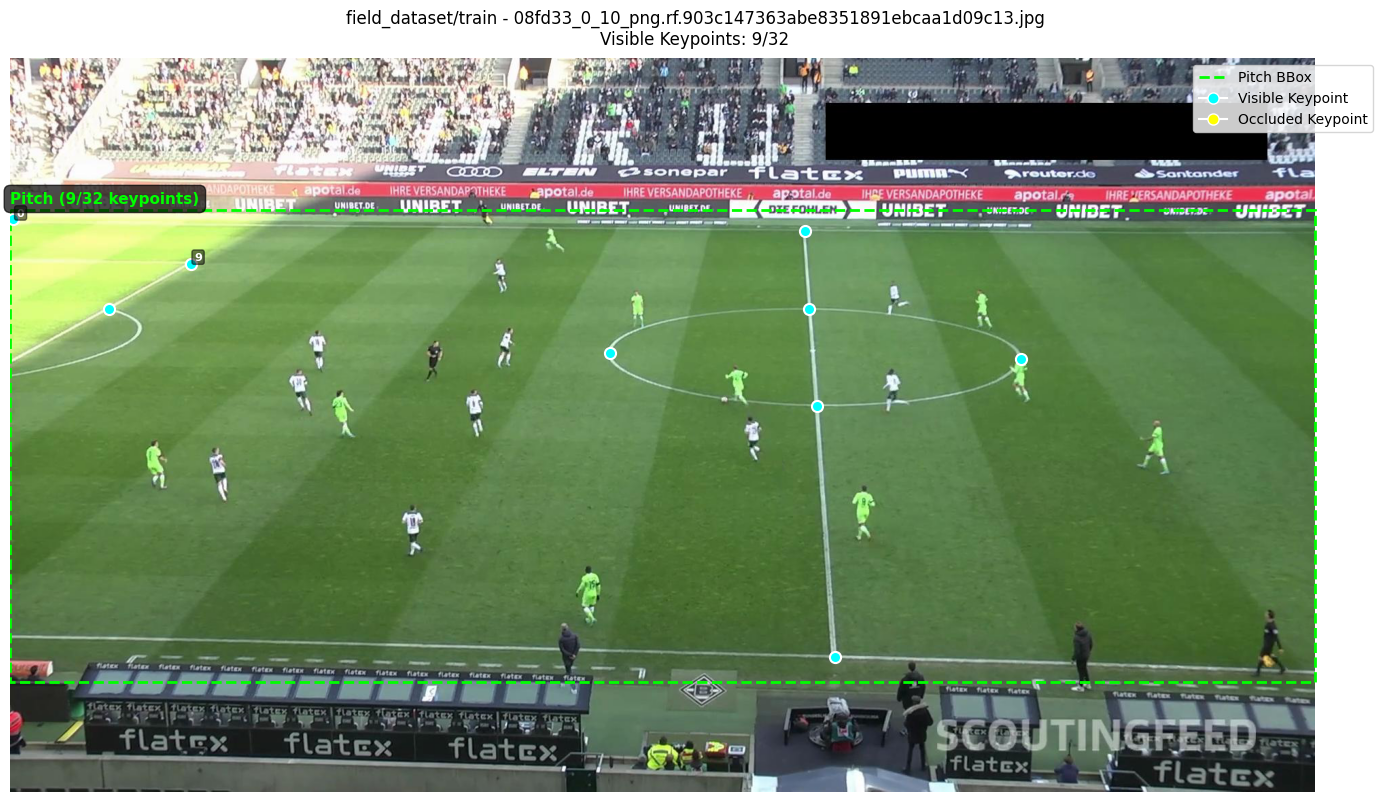


=== Validation Set Sample ===


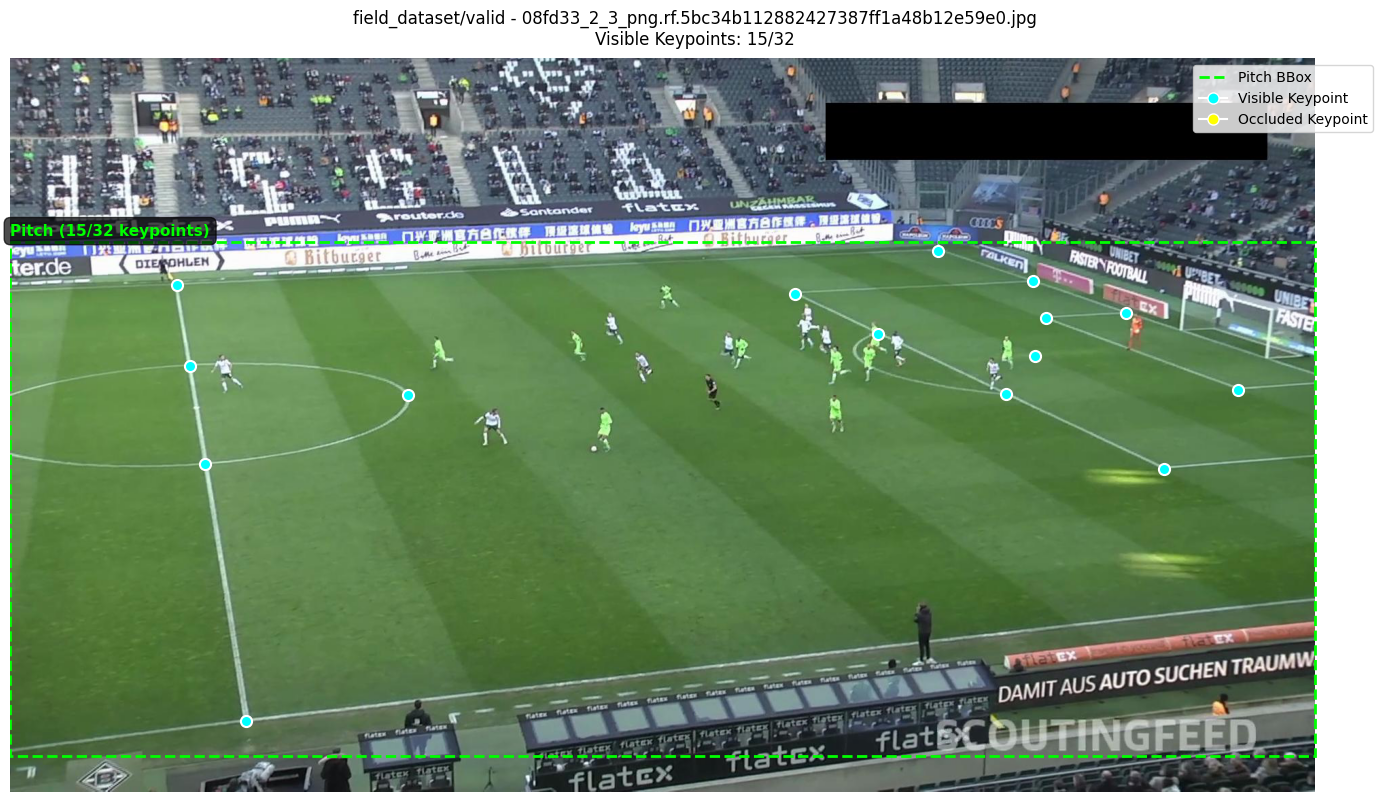


=== Test Set Sample ===


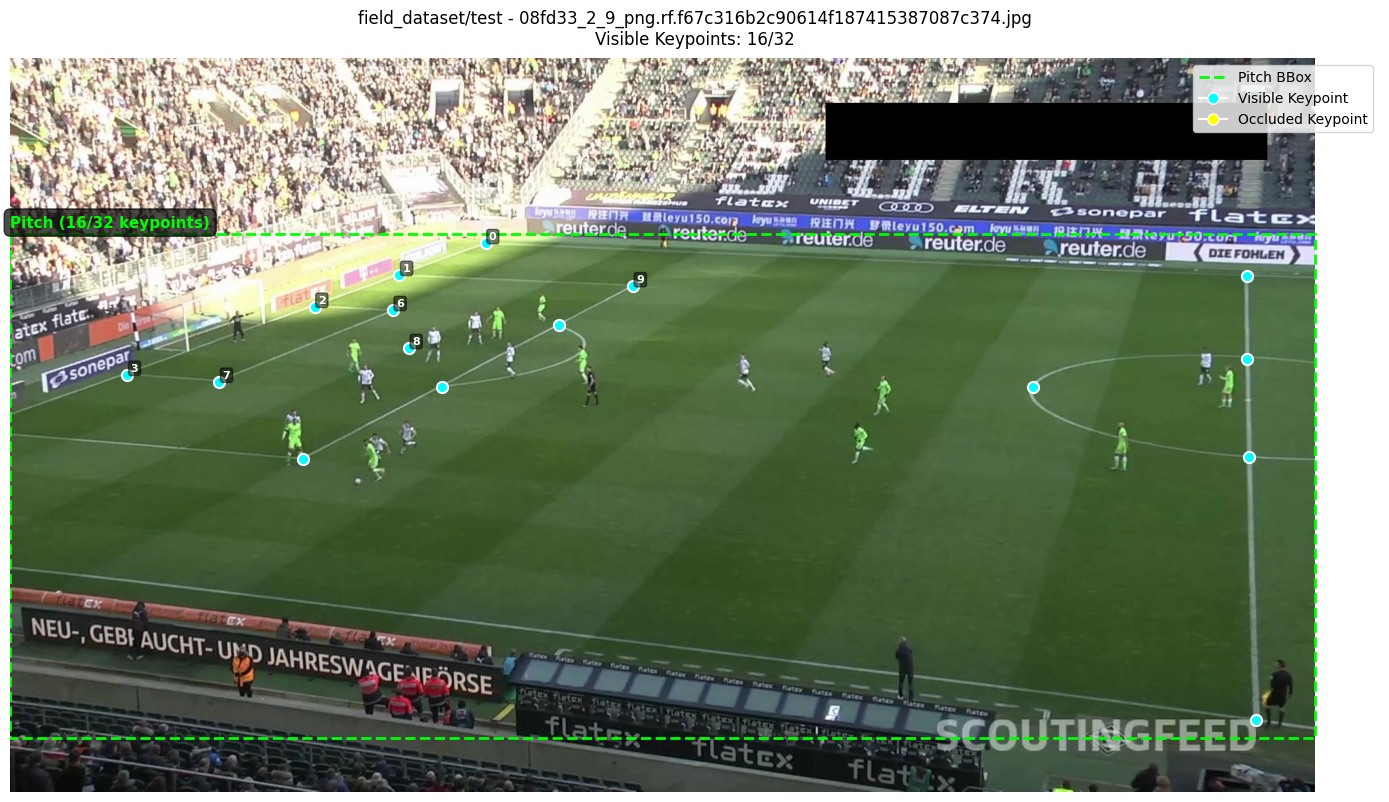

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define colors for pitch and keypoints
PITCH_COLOR = 'lime'
KEYPOINT_COLORS = {
    0: 'red',      # Not labeled
    1: 'yellow',   # Labeled but occluded
    2: 'cyan'      # Labeled and visible
}

def visualize_sample(df, idx, figsize=(14, 10)):
    """
    Visualize an image with its pitch bounding box and keypoints.
    """
    row = df.iloc[idx]
    
    # Load image
    img = Image.open(row['image_path'])
    img_width, img_height = img.size
    
    # Create figure
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    
    # Draw pitch annotations
    for ann in row['annotations']:
        # Convert from YOLO format to corner format for bounding box
        x_center = ann['x_center'] * img_width
        y_center = ann['y_center'] * img_height
        width = ann['width'] * img_width
        height = ann['height'] * img_height
        
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        
        # Draw bounding box
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor=PITCH_COLOR, facecolor='none', linestyle='--'
        )
        ax.add_patch(rect)
        
        # Draw keypoints
        for kpt_idx, (kpt_x, kpt_y, kpt_vis) in enumerate(ann['keypoints']):
            if kpt_vis > 0:  # Only draw labeled keypoints
                x_pixel = kpt_x * img_width
                y_pixel = kpt_y * img_height
                color = KEYPOINT_COLORS[kpt_vis]
                
                # Draw keypoint
                ax.plot(x_pixel, y_pixel, 'o', color=color, markersize=8, 
                       markeredgecolor='white', markeredgewidth=1.5)
                
                # Optionally add keypoint number for first few keypoints
                if kpt_idx < 10:  # Only label first 10 to avoid clutter
                    ax.text(x_pixel + 5, y_pixel - 5, str(kpt_idx), 
                           fontsize=8, color='white', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.5))
        
        # Add legend info
        ax.text(
            x_min, y_min - 10,
            f"Pitch ({ann['num_visible_keypoints']}/{NUM_KEYPOINTS} keypoints)",
            color=PITCH_COLOR,
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='black', alpha=0.7)
        )
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=PITCH_COLOR, linestyle='--', linewidth=2, label='Pitch BBox'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=KEYPOINT_COLORS[2], 
               markersize=8, label='Visible Keypoint', markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=KEYPOINT_COLORS[1], 
               markersize=8, label='Occluded Keypoint', markeredgecolor='white')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    ax.axis('off')
    ax.set_title(f"{row['split']} - {row['filename']}\nVisible Keypoints: {row['avg_visible_keypoints']:.0f}/{NUM_KEYPOINTS}", 
                fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()

# Visualize samples
print("=== Training Set Sample ===")
visualize_sample(train_df, 0)

print("\n=== Validation Set Sample ===")
visualize_sample(valid_df, 0)

print("\n=== Test Set Sample ===")
visualize_sample(test_df, 0)


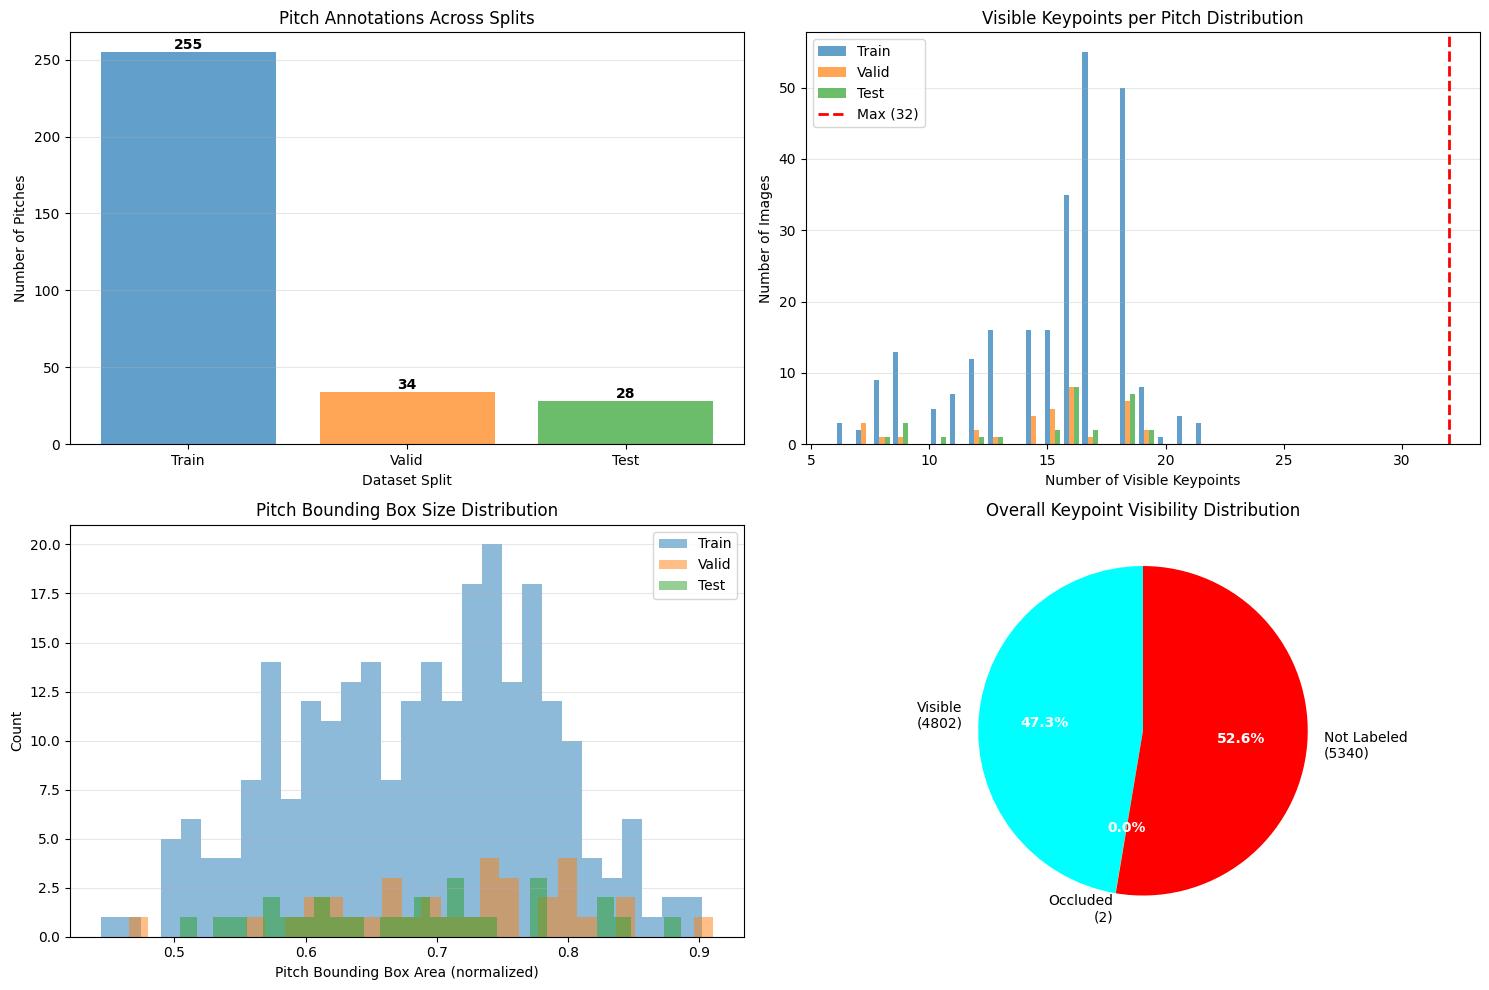


=== Summary Statistics ===
Total dataset size: 317 images
Total pitches: 317
Average visible keypoints per pitch: 15.15 / 32

Keypoint visibility breakdown:
  Visible (vis=2): 4802 (47.3%)
  Occluded (vis=1): 2 (0.0%)
  Not labeled (vis=0): 5340 (52.6%)
  Total keypoints: 10144


In [30]:
# Pitch keypoint analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Pitch count across splits
ax = axes[0, 0]
split_names = ['Train', 'Valid', 'Test']
pitch_counts = [train_df['num_pitches'].sum(), valid_df['num_pitches'].sum(), test_df['num_pitches'].sum()]

bars = ax.bar(split_names, pitch_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Number of Pitches')
ax.set_title('Pitch Annotations Across Splits')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# 2. Visible keypoints distribution
ax = axes[0, 1]
ax.hist([train_df['avg_visible_keypoints'], valid_df['avg_visible_keypoints'], test_df['avg_visible_keypoints']], 
        label=['Train', 'Valid', 'Test'], bins=20, alpha=0.7)
ax.set_xlabel('Number of Visible Keypoints')
ax.set_ylabel('Number of Images')
ax.set_title('Visible Keypoints per Pitch Distribution')
ax.axvline(x=NUM_KEYPOINTS, color='red', linestyle='--', linewidth=2, label=f'Max ({NUM_KEYPOINTS})')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Bounding box size distribution (area)
ax = axes[1, 0]
for split_name, df in [('Train', train_df), ('Valid', valid_df), ('Test', test_df)]:
    all_areas = []
    for anns in df['annotations']:
        for ann in anns:
            area = ann['width'] * ann['height']  # Normalized area
            all_areas.append(area)
    if all_areas:
        ax.hist(all_areas, bins=30, alpha=0.5, label=split_name)

ax.set_xlabel('Pitch Bounding Box Area (normalized)')
ax.set_ylabel('Count')
ax.set_title('Pitch Bounding Box Size Distribution')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 4. Keypoint visibility statistics
ax = axes[1, 1]
all_df = pd.concat([train_df, valid_df, test_df])

# Calculate visibility statistics
total_keypoints = 0
visible_keypoints = 0
occluded_keypoints = 0
not_labeled_keypoints = 0

for anns in all_df['annotations']:
    for ann in anns:
        for _, _, vis in ann['keypoints']:
            total_keypoints += 1
            if vis == 2:
                visible_keypoints += 1
            elif vis == 1:
                occluded_keypoints += 1
            else:
                not_labeled_keypoints += 1

visibility_data = [visible_keypoints, occluded_keypoints, not_labeled_keypoints]
visibility_labels = [f'Visible\n({visible_keypoints})', 
                     f'Occluded\n({occluded_keypoints})', 
                     f'Not Labeled\n({not_labeled_keypoints})']
colors_list = [KEYPOINT_COLORS[2], KEYPOINT_COLORS[1], KEYPOINT_COLORS[0]]

wedges, texts, autotexts = ax.pie(visibility_data, labels=visibility_labels, autopct='%1.1f%%', 
                                    colors=colors_list, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax.set_title('Overall Keypoint Visibility Distribution')

plt.tight_layout()
plt.show()

print("\n=== Summary Statistics ===")
print(f"Total dataset size: {len(train_df) + len(valid_df) + len(test_df)} images")
print(f"Total pitches: {all_df['num_pitches'].sum()}")
print(f"Average visible keypoints per pitch: {all_df['avg_visible_keypoints'].mean():.2f} / {NUM_KEYPOINTS}")
print(f"\nKeypoint visibility breakdown:")
print(f"  Visible (vis=2): {visible_keypoints} ({100*visible_keypoints/total_keypoints:.1f}%)")
print(f"  Occluded (vis=1): {occluded_keypoints} ({100*occluded_keypoints/total_keypoints:.1f}%)")
print(f"  Not labeled (vis=0): {not_labeled_keypoints} ({100*not_labeled_keypoints/total_keypoints:.1f}%)")
print(f"  Total keypoints: {total_keypoints}")


#### 2. Data Preprocessing

##### 2.1. Random image augmentation (rotation)

In [31]:
import cv2
import random
from PIL import Image
import shutil

def rotate_bbox_90(x_center, y_center, width, height, angle):
    """
    Rotate bounding box coordinates for 90, 180, or 270 degree rotations.
    """
    if angle == 90:
        new_x_center = 1 - y_center
        new_y_center = x_center
        new_width = height
        new_height = width
    elif angle == 180:
        new_x_center = 1 - x_center
        new_y_center = 1 - y_center
        new_width = width
        new_height = height
    elif angle == 270:
        new_x_center = y_center
        new_y_center = 1 - x_center
        new_width = height
        new_height = width
    else:
        raise ValueError(f"Angle must be 90, 180, or 270, got {angle}")
    
    return new_x_center, new_y_center, new_width, new_height

def rotate_keypoint_90(x, y, angle):
    """
    Rotate keypoint coordinates for 90, 180, or 270 degree rotations.
    """
    if angle == 90:
        new_x = 1 - y
        new_y = x
    elif angle == 180:
        new_x = 1 - x
        new_y = 1 - y
    elif angle == 270:
        new_x = y
        new_y = 1 - x
    else:
        raise ValueError(f"Angle must be 90, 180, or 270, got {angle}")
    
    return new_x, new_y

def rotate_image_90(image_path, angle):
    """
    Rotate an image by 90, 180, or 270 degrees.
    """
    img = Image.open(image_path)
    
    if angle == 90:
        rotated = img.rotate(-90, expand=True)
    elif angle == 180:
        rotated = img.rotate(-180, expand=True)
    elif angle == 270:
        rotated = img.rotate(-270, expand=True)
    else:
        raise ValueError(f"Angle must be 90, 180, or 270, got {angle}")
    
    return rotated

def augment_dataset_with_rotations(df, split_name, augmentation_prob=0.5, rotation_angles=[90, 180, 270]):
    """
    Apply random rotation augmentations to a dataset split with keypoint support.
    """
    augmented_data = []
    
    # Create augmented directories
    aug_images_dir = Path(split_name) / 'images_augmented'
    aug_labels_dir = Path(split_name) / 'labels_augmented'
    aug_images_dir.mkdir(exist_ok=True)
    aug_labels_dir.mkdir(exist_ok=True)
    
    print(f"\nAugmenting {split_name} set...")
    
    for idx, row in df.iterrows():
        if random.random() < augmentation_prob:
            angle = random.choice(rotation_angles)
            
            original_img_path = row['image_path']
            rotated_img = rotate_image_90(original_img_path, angle)
            
            base_filename = Path(row['filename']).stem
            new_filename = f"{base_filename}_rot{angle}.jpg"
            new_img_path = aug_images_dir / new_filename
            new_label_path = aug_labels_dir / f"{base_filename}_rot{angle}.txt"
            
            rotated_img.save(new_img_path)
            
            rotated_annotations = []
            with open(new_label_path, 'w') as f:
                for ann in row['annotations']:
                    # Rotate bounding box
                    new_x, new_y, new_w, new_h = rotate_bbox_90(
                        ann['x_center'], ann['y_center'],
                        ann['width'], ann['height'],
                        angle
                    )
                    
                    # Rotate keypoints
                    rotated_keypoints = []
                    num_visible_keypoints = 0
                    for kpt_x, kpt_y, kpt_vis in ann['keypoints']:
                        if kpt_vis > 0:
                            new_kpt_x, new_kpt_y = rotate_keypoint_90(kpt_x, kpt_y, angle)
                            rotated_keypoints.append((new_kpt_x, new_kpt_y, kpt_vis))
                            num_visible_keypoints += 1
                        else:
                            rotated_keypoints.append((kpt_x, kpt_y, kpt_vis))
                    
                    # Write to label file (format: class_id x y w h kpt1_x kpt1_y kpt1_vis ...)
                    label_line = f"{ann['class_id']} {new_x} {new_y} {new_w} {new_h}"
                    for kpt_x, kpt_y, kpt_vis in rotated_keypoints:
                        label_line += f" {kpt_x} {kpt_y} {kpt_vis}"
                    f.write(label_line + "\n")
                    
                    rotated_annotations.append({
                        'class_id': ann['class_id'],
                        'class_name': ann['class_name'],
                        'x_center': new_x,
                        'y_center': new_y,
                        'width': new_w,
                        'height': new_h,
                        'keypoints': rotated_keypoints,
                        'num_visible_keypoints': num_visible_keypoints
                    })
            
            augmented_data.append({
                'image_path': str(new_img_path),
                'label_path': str(new_label_path),
                'filename': new_filename,
                'split': split_name,
                'annotations': rotated_annotations,
                'augmented': True,
                'augmentation_type': f'rotation_{angle}'
            })
            
            if (idx + 1) % 50 == 0:
                print(f"  Processed {idx + 1}/{len(df)} images...")
    
    print(f"  Created {len(augmented_data)} augmented samples")
    
    if augmented_data:
        aug_df = pd.DataFrame(augmented_data)
        aug_df['num_pitches'] = aug_df['annotations'].apply(len)
        aug_df['avg_visible_keypoints'] = aug_df['annotations'].apply(
            lambda anns: np.mean([ann['num_visible_keypoints'] for ann in anns]) if anns else 0
        )
        
        df_copy = df.copy()
        df_copy['augmented'] = False
        df_copy['augmentation_type'] = 'original'
        
        combined_df = pd.concat([df_copy, aug_df], ignore_index=True)
        return combined_df
    else:
        df_copy = df.copy()
        df_copy['augmented'] = False
        df_copy['augmentation_type'] = 'original'
        return df_copy

print("Augmentation functions defined successfully!")


Augmentation functions defined successfully!


In [32]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("=" * 70)
print("APPLYING ROTATION AUGMENTATIONS")
print("=" * 70)

# Apply augmentation to training set (50% of images)
train_df_augmented = augment_dataset_with_rotations(
    train_df, 
    'field_dataset/train', 
    augmentation_prob=0.5,
    rotation_angles=[90, 180, 270]
)

# Apply augmentation to validation set (30% of images)
valid_df_augmented = augment_dataset_with_rotations(
    valid_df, 
    'field_dataset/valid', 
    augmentation_prob=0.3,
    rotation_angles=[90, 180, 270]
)

# Apply augmentation to test set (30% of images)
test_df_augmented = augment_dataset_with_rotations(
    test_df, 
    'field_dataset/test', 
    augmentation_prob=0.3,
    rotation_angles=[90, 180, 270]
)

print("\n" + "=" * 70)
print("AUGMENTATION COMPLETE")
print("=" * 70)

# Display updated statistics
print("\n=== UPDATED DATASET STATISTICS (with augmentation) ===")
for split_name, df in [('Train', train_df_augmented), ('Validation', valid_df_augmented), ('Test', test_df_augmented)]:
    original_count = len(df[df['augmented'] == False])
    augmented_count = len(df[df['augmented'] == True])
    
    print(f"\n{split_name} Set:")
    print(f"  Original images: {original_count}")
    print(f"  Augmented images: {augmented_count}")
    print(f"  Total images: {len(df)}")
    print(f"  Total pitches: {df['num_pitches'].sum()}")
    print(f"  Avg pitches per image: {df['num_pitches'].mean():.2f}")
    print(f"  Avg visible keypoints per pitch: {df['avg_visible_keypoints'].mean():.2f} / {NUM_KEYPOINTS}")
    
    # Show augmentation type distribution
    if augmented_count > 0:
        print(f"  Augmentation types:")
        for aug_type in df[df['augmented'] == True]['augmentation_type'].value_counts().items():
            print(f"    {aug_type[0]}: {aug_type[1]} images")

# Update the original dataframes with augmented versions
train_df = train_df_augmented
valid_df = valid_df_augmented
test_df = test_df_augmented

print("\n✓ DataFrames updated with augmented data!")


APPLYING ROTATION AUGMENTATIONS

Augmenting field_dataset/train set...
  Processed 50/255 images...
  Created 125 augmented samples

Augmenting field_dataset/valid set...
  Created 12 augmented samples

Augmenting field_dataset/test set...
  Created 5 augmented samples

AUGMENTATION COMPLETE

=== UPDATED DATASET STATISTICS (with augmentation) ===

Train Set:
  Original images: 255
  Augmented images: 125
  Total images: 380
  Total pitches: 380
  Avg pitches per image: 1.00
  Avg visible keypoints per pitch: 15.22 / 32
  Augmentation types:
    rotation_270: 52 images
    rotation_90: 39 images
    rotation_180: 34 images

Validation Set:
  Original images: 34
  Augmented images: 12
  Total images: 46
  Total pitches: 46
  Avg pitches per image: 1.00
  Avg visible keypoints per pitch: 14.26 / 32
  Augmentation types:
    rotation_180: 5 images
    rotation_270: 5 images
    rotation_90: 2 images

Test Set:
  Original images: 28
  Augmented images: 5
  Total images: 33
  Total pitches: 

VISUALIZING ORIGINAL VS AUGMENTED IMAGES

Showing original pitch images with their rotated augmentations...
(Lime=pitch bbox, Cyan=visible keypoint, Yellow=occluded keypoint)


--- Training Example 1 ---


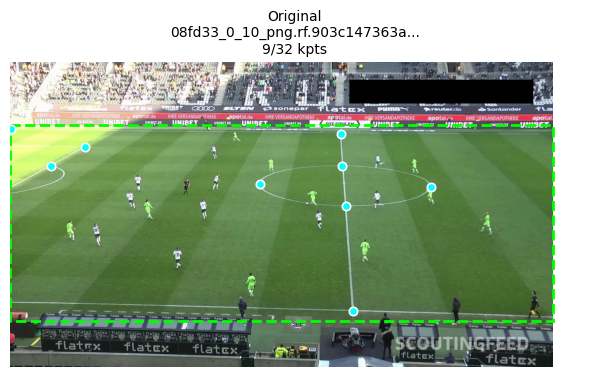


--- Training Example 2 ---


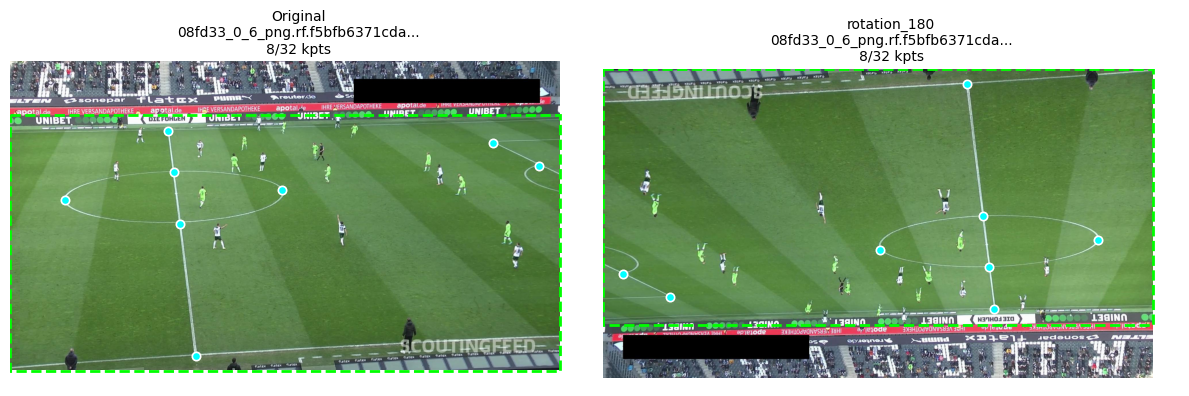


--- Training Example 3 ---


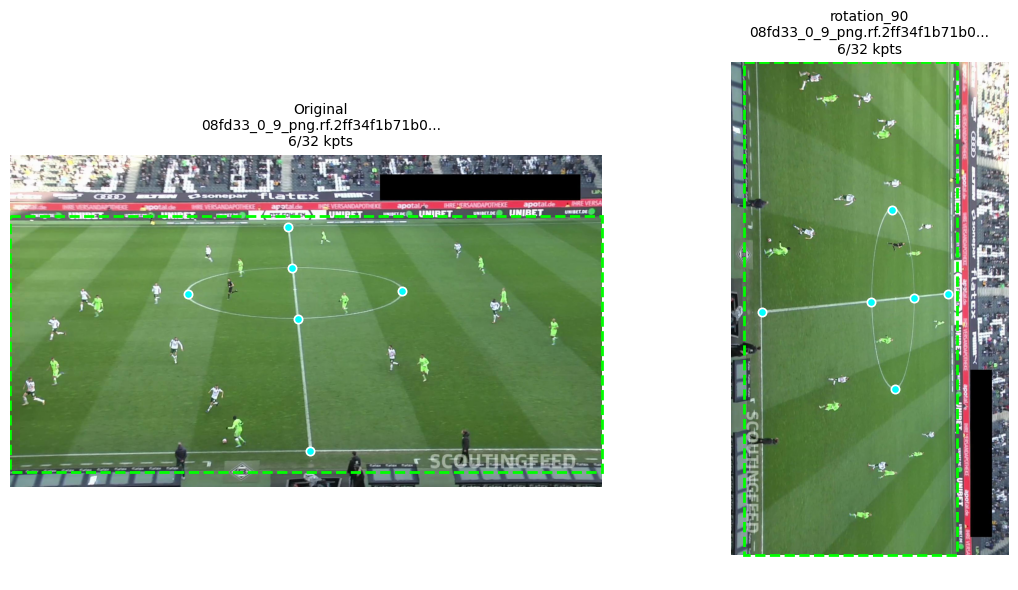

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_pitch_annotation(ax, ann, img_width, img_height):
    """
    Helper function to draw pitch bounding box and keypoints on an axis.
    """
    # Draw bounding box
    x_center = ann['x_center'] * img_width
    y_center = ann['y_center'] * img_height
    width = ann['width'] * img_width
    height = ann['height'] * img_height
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=PITCH_COLOR, facecolor='none', linestyle='--'
    )
    ax.add_patch(rect)
    
    # Draw keypoints
    for kpt_x, kpt_y, kpt_vis in ann['keypoints']:
        if kpt_vis > 0:  # Only draw labeled keypoints
            x_pixel = kpt_x * img_width
            y_pixel = kpt_y * img_height
            color = KEYPOINT_COLORS[kpt_vis]
            
            ax.plot(x_pixel, y_pixel, 'o', color=color, markersize=6, 
                   markeredgecolor='white', markeredgewidth=1.2)

def visualize_original_vs_augmented(df, original_idx):
    """
    Visualize an original pitch image and its augmented versions side by side.
    """
    # Get original image
    original_row = df[(df['augmented'] == False)].iloc[original_idx]
    original_filename_stem = Path(original_row['filename']).stem
    
    # Find augmented versions
    augmented_rows = df[
        (df['augmented'] == True) & 
        (df['filename'].str.contains(original_filename_stem))
    ]
    
    # Create subplots
    num_images = 1 + len(augmented_rows)
    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
    
    if num_images == 1:
        axes = [axes]
    
    # Plot original
    img = Image.open(original_row['image_path'])
    img_width, img_height = img.size
    axes[0].imshow(img)
    
    for ann in original_row['annotations']:
        draw_pitch_annotation(axes[0], ann, img_width, img_height)
    
    axes[0].axis('off')
    axes[0].set_title(f"Original\n{original_row['filename'][:30]}...\n{original_row['avg_visible_keypoints']:.0f}/{NUM_KEYPOINTS} kpts", 
                     fontsize=10)
    
    # Plot augmented versions
    for idx, (_, aug_row) in enumerate(augmented_rows.iterrows(), start=1):
        img = Image.open(aug_row['image_path'])
        img_width, img_height = img.size
        axes[idx].imshow(img)
        
        for ann in aug_row['annotations']:
            draw_pitch_annotation(axes[idx], ann, img_width, img_height)
        
        axes[idx].axis('off')
        axes[idx].set_title(f"{aug_row['augmentation_type']}\n{aug_row['filename'][:30]}...\n{aug_row['avg_visible_keypoints']:.0f}/{NUM_KEYPOINTS} kpts", 
                           fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("=" * 70)
print("VISUALIZING ORIGINAL VS AUGMENTED IMAGES")
print("=" * 70)
print("\nShowing original pitch images with their rotated augmentations...")
print("(Lime=pitch bbox, Cyan=visible keypoint, Yellow=occluded keypoint)\n")

# Visualize a few examples from training set
for i in range(min(3, len(train_df[train_df['augmented'] == False]))):
    print(f"\n--- Training Example {i+1} ---")
    visualize_original_vs_augmented(train_df, i)


In [34]:
# Save augmented dataframes to CSV for future reference
print("=" * 70)
print("SAVING AUGMENTED DATASET INFORMATION")
print("=" * 70)

train_df.to_csv('train_augmented.csv', index=False)
valid_df.to_csv('valid_augmented.csv', index=False)
test_df.to_csv('test_augmented.csv', index=False)

print("\n✓ Saved augmented dataset info to CSV files:")
print("  - field_dataset/train_augmented.csv")
print("  - field_dataset/valid_augmented.csv")
print("  - field_dataset/test_augmented.csv")

SAVING AUGMENTED DATASET INFORMATION

✓ Saved augmented dataset info to CSV files:
  - field_dataset/train_augmented.csv
  - field_dataset/valid_augmented.csv
  - field_dataset/test_augmented.csv
